# Predict the City Affiliation of a Dutch Neighbourhood

In [1]:
import math
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#import scipy.stats as stats
#plt.rc('figure', figsize=(10, 6))
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df=pd.read_excel('kwb-2016.xls', decimal=",")
df.size

874476

<b>Data Preparation</b>

a) Clean the data

In [3]:
#1. Drop missing values
df.replace('.', np.nan, inplace=True)
df.dropna(how='any', inplace=True)

#2. Select neighborhoods
df = df[df['recs']=='Buurt']

#3. Select cities: Rotterdam, Lelystad and Venlo 
df = df[df['gm_naam'].isin(['Rotterdam','Lelystad', 'Venlo'])]

df.shape

(196, 54)

b) Engineer some features

In [4]:
#1. Transform all demographic columns

#1a.Transform all numerical columns into int64 or float64
df = df.apply(pd.to_numeric, errors='ignore')
#df.dtypes

#1b.Transform all demographic columns by dividing them by the total inhabitants (a_inw) of the neighbourhood
#Remove records with zero number of inhabitants - altough are non-existent in the selected dataset
df = df[df['a_inw'] != 0]
    
filter_col = [col for col in df.iloc[0:,3:] if col.startswith('a_')]
df[filter_col] = df[filter_col].div(df['a_inw'], axis=0)
df.head(5)       
    
#2. Apply any other feature engineering tricks
#Scaling X - Transforms the data such that its distribution has a mean value 0 and standard deviation of 1
#Done after the train-test split, in b)

,gm_naam,recs,a_inw,a_man,a_15_24,a_25_44,a_45_64,a_65_oo,a_gehuwd,a_gesch,...,a_lfto6j,a_bst_nb,g_pau_hh,g_pau_km,a_m2w,g_afs_gs,a_lan_ha,a_wat_ha,ste_mvs,ste_oad
8611,Rotterdam,Buurt,14825,0.521079,0.146712,0.471838,0.188533,0.117032,0.213828,0.074874,...,0.203373,0.152108,0.8,6042,0.025970,0.3,0.009174,0.002496,1,6383
8612,Rotterdam,Buurt,9350,0.506952,0.158289,0.305882,0.252941,0.141176,0.236364,0.116043,...,0.171658,0.056684,0.5,4024,0.011230,0.3,0.006096,0.000000,1,6397
8613,Rotterdam,Buurt,5395,0.515292,0.121409,0.469880,0.196478,0.131603,0.189064,0.102873,...,0.181650,0.073216,0.5,2581,0.014829,0.2,0.011307,0.000000,1,6283
8615,Rotterdam,Buurt,1575,0.552381,0.279365,0.285714,0.228571,0.146032,0.266667,0.060317,...,0.260317,0.158730,0.8,1261,0.025397,0.5,0.044444,0.021587,1,3472
8616,Rotterdam,Buurt,710,0.478873,0.281690,0.528169,0.077465,0.056338,0.105634,0.035211,...,0.176056,0.056338,0.3,375,0.014085,0.6,0.070423,0.002817,1,5416


b) Create train-test split [the split is 0.25/0.75 by default]

In [5]:
#1. Extract Y
y = df['gm_naam']

#2. Extract X
X = df.iloc[0:,3:]
X = np.array(X)

In [6]:
#3. Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)
X_train.shape
X_test.shape

(147, 51)

(49, 51)

In [7]:
#4. Scaling 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

<b>Logistic Regression</b>

a) Estimate a logistic regression model on the training set, with 5-fold cross validation,
with grid search over the regularization parameter

In [8]:
from sklearn.linear_model import LogisticRegression

param_grid = {'C': np.power(10.0, np.arange(-5, 5))}
grid = GridSearchCV(LogisticRegression(), param_grid, return_train_score = True, cv=5).fit(X_train_scaled, y_train)

print ("Best performance: {: .3f}".format(grid.best_score_))
print ("Best param: ", grid.best_params_)

Best performance:  0.946
Best param:  {'C': 10.0}


b) Plot the validation curve (mean train/test performance for all values of the regularization
parameter)

In [9]:
lr_train_scores = grid.cv_results_['mean_train_score']
lr_test_scores = grid.cv_results_['mean_test_score']
cs = np.power(10.0, np.arange(-5, 5))

Text(0.5,1,'LogisticRegression Model Performance')

Text(0.5,0,'C')

Text(0,0.5,'Score')

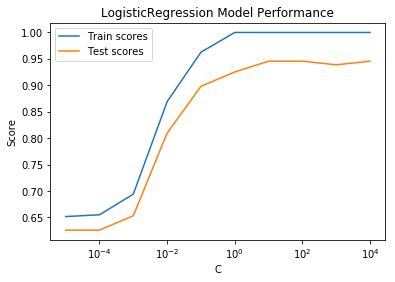

In [10]:
plt.figure()
plt.title('LogisticRegression Model Performance')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Score')

plt.plot(cs, lr_train_scores, label="Train scores")
plt.plot(cs, lr_test_scores, label="Test scores")
plt.legend(loc='best')

c) What’s the best performance and at what regularization parameter?

The best accuracy on the given test data is <b>Score = 0.946</b><br>
For the regularization parameter: <b>C = 10</b>

<b>SVM</b>

a) Estimate an SVM model on the training set, with 5-fold cross validation, with grid search over the regularization parameter. Make sure you apply some form of feature normalization

In [11]:
from sklearn import svm

#Use the standard scaler value of X_train: X_train_scaled
param_grid = {'C': np.power(10.0, np.arange(-5, 5))}
grid = GridSearchCV(svm.SVC(), param_grid, return_train_score = True, cv=5).fit(X_train_scaled, y_train)

print ("Best performance: {: .3f}".format(grid.best_score_))
print ("Best param: ", grid.best_params_)

Best performance:  0.939
Best param:  {'C': 10.0}


b) Plot the validation curve (mean train/test performance for all values of the regularization
parameter)

In [12]:
svm_train_scores = grid.cv_results_['mean_train_score']
svm_test_scores = grid.cv_results_['mean_test_score']
cs = np.power(10.0, np.arange(-5, 5))

Text(0.5,1,'SVM Model Performance')

Text(0.5,0,'C')

Text(0,0.5,'Score')

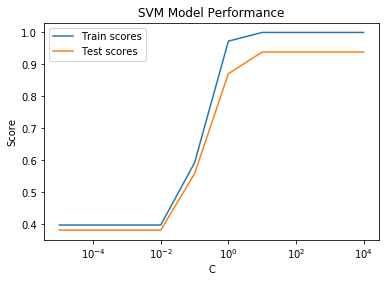

In [13]:
plt.figure()
plt.title('SVM Model Performance')
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('Score')

plt.plot(cs, svm_train_scores, label="Train scores")
plt.plot(cs, svm_test_scores, label="Test scores")
plt.legend(loc='best')

c) What’s the best performance and at what regularization parameter?

The best accuracy on the given test data is <b>Score = 0.939</b><br>
For the regularization parameter: <b>C = 10</b>

<b>Make the best possible model</b>

a) Use all the tools you have learned so far to create the best possible model you can
for this problem

<b>Covariance Matrix</b>

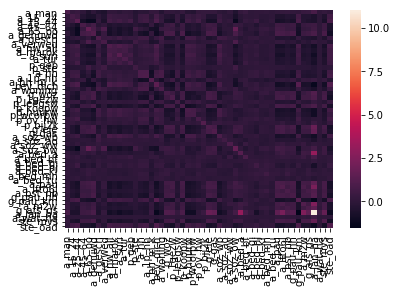

In [14]:
from scipy.cluster import hierarchy
cov = np.cov(X_test_scaled, rowvar=False)

order = np.array(hierarchy.dendrogram(hierarchy.ward(cov), no_plot=True)['ivl'], dtype="int")
sns.heatmap(cov, xticklabels=df.iloc[0:,3:].columns, yticklabels=df.iloc[0:,3:].columns)

<b>Feature Selection</b>

<Container object of 51 artists>

Text(0.5,1,'Feature Importance')

Text(0.5,0,'Feature name')

(-2.7750000000000004, 52.775, 0.0, 0.14736110094210925)

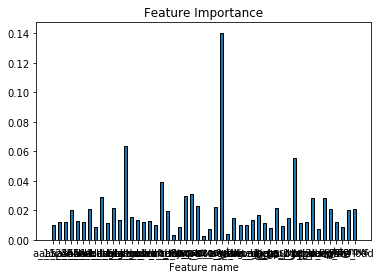

In [18]:
from sklearn.ensemble import ExtraTreesClassifier

eclf = ExtraTreesClassifier(random_state=10).fit(X_train_scaled, y_train)
idx = [i for i,x in enumerate(eclf.feature_importances_) if x >=0.01]
new_X_train_scaled = X_train_scaled[idx]
new_y_train = np.array(y_train)[idx]

plt.bar(df.iloc[0:,3:].columns, eclf.feature_importances_, width=.5, edgecolor='black')
plt.title("Feature Importance")
plt.xlabel("Feature name")
#plt.xticks(rotation='vertical')
plt.axis('tight')

In [19]:
param_grid = {'C': np.power(10.0, np.arange(-5, 5))}
grid = GridSearchCV(LogisticRegression(penalty='l1'), param_grid, cv=5).fit(X_train_scaled, y_train)

print ("Best performance: {: .3f}".format(grid.best_score_))
print ("Best param: ", grid.best_params_)

Best performance:  0.952
Best param:  {'C': 100.0}


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

<Container object of 51 artists>

Text(0.5,1,'Feature selection')

Text(0.5,0,'Feature number')

(-2.555, 52.55500000000001, 0.0, 1.05)

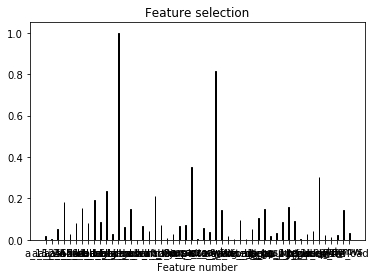

In [20]:

clf = svm.SVC(kernel='linear')
clf.fit(X_train_scaled, y_train)

svm_weights = (clf.coef_ ** 2).sum(axis=0)
svm_weights /= svm_weights.max()

plt.bar(df.iloc[0:,3:].columns, svm_weights, width=.1, color='c', edgecolor='black')
plt.title("Feature selection")
plt.xlabel('Feature number')
#plt.yticks(())
#plt.xticks(rotation=90)
plt.axis('tight')

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

[array([-0.0518086 , -0.35646123,  0.40751413,  0.29673616,  0.14892409,
        -0.05137489, -0.85694868,  0.39947618,  0.59073065, -0.14793632,
         0.89182282, -0.02119662, -0.06376324,  0.21575094, -0.05722645,
        -0.1255422 ,  0.68913208, -0.04102022,  0.01818719,  0.18499489,
        -1.07987485,  0.55936465, -0.41625767,  0.33823529,  0.23641975,
         0.15132368,  0.53588378, -0.47488964, -0.62849034, -0.15857315,
        -1.39484234, -0.49115605,  0.10193386, -0.04778689,  0.36587918,
        -0.97670407,  0.99939039,  0.29666426,  0.56493379, -0.04054021,
         0.03269755, -0.53975611, -1.48516702,  0.01275494, -0.31589685,
         0.08391243,  0.0686966 ,  0.36272593,  0.35532117,  0.29824592,
         0.52299243]),
 array([-0.19312814, -0.65626227,  1.10220414,  0.47554616,  0.37990701,
        -0.27695111, -1.65856886,  0.91960712,  1.04053135, -0.30946755,
         1.85711153, -0.17474738, -0.05712156,  0.29746517, -0.00860029,
        -0.13508654,  1.3331

[1, 10, 100, 1000, 10000]

Text(0.5,0,'C')

Text(0,0.5,'weight coefficient')

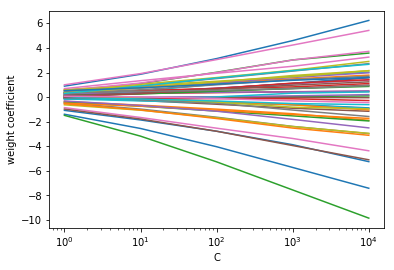

In [21]:
coef, params = [], []
for c in np.arange(0, 5):
   lr = LogisticRegression(C=10**c)
   lr.fit(X_train_scaled, y_train)
   coef.append(lr.coef_[1])
   params.append(10**c)

coef
params

coef = np.array(coef)

# Decision region drawing
plt.plot(params, coef)
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('weight coefficient')



In [144]:
# sns.stripplot(x=df.gm_naam, y=df.a_inw)

In [48]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'max_depth': np.arange(3, 10), 'n_estimators': np.arange(50, 100, 10)}  # max_features=5,
grid = GridSearchCV(RandomForestClassifier(random_state=10), param_grid, return_train_score = True, cv=5).fit(X_train_scaled, y_train)
print ("Best performance: {: .3f}".format(grid.best_score_))
print ("Best param: ", grid.best_params_)

Best performance:  0.912
Best param:  {'max_depth': 4, 'n_estimators': 90}


In [77]:
scores = cross_val_score(LogisticRegression(C=10), X_train_scaled, y_train)
scores.mean()

param_grid = {'C': np.power(10.0, np.arange(-5, 5))}
grid = GridSearchCV(LogisticRegression(), param_grid, return_train_score = True, cv=5).fit(X_train_scaled, y_train)
print ("Best performance: {: .3f}".format(grid.best_score_))
print ("Best param: ", grid.best_params_)

#grid.best_estimator_.coef_

0.9390362811791384

Best performance:  0.946
Best param:  {'C': 10.0}


In [23]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': np.arange(2, 10)}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, return_train_score = True, cv=5).fit(X_train_scaled, y_train)
print ("Best performance: {: .3f}".format(grid.best_score_))
print ("Best param: ", grid.best_params_)

Best performance:  0.850
Best param:  {'n_neighbors': 4}


In [24]:
clf = KNeighborsClassifier(n_neighbors = 5)
clf.fit(X_train_scaled, y_train)
clf.score(X_train_scaled, y_train)

score = cross_val_score(KNeighborsClassifier(n_neighbors = 5), X_train_scaled, y_train)
score.mean()


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

0.9523809523809523

0.7830839002267574

In [63]:
from sklearn.linear_model import SGDClassifier

param_grid = {'alpha': np.power(10.0, np.arange(-5, 5))}
clf = SGDClassifier(loss='hinge', penalty='elasticnet', l1_ratio=0.15, max_iter=5, shuffle=True, verbose=False, average=False, class_weight='balanced')
sgd_grid = GridSearchCV(clf, param_grid, cv=5, scoring='f1_macro').fit(X_train_scaled, y_train)
print(sgd_grid.best_params_)    
print(sgd_grid.best_score_)   


for i in range(0, sgd_grid.best_estimator_.coef_.shape[0]):
    top10 = np.argsort(sgd_grid.best_estimator_.coef_[i])[-10:]

{'alpha': 0.01}
0.9042079460798667


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

In [26]:
#Select top 10 features
from sklearn.feature_selection import SelectKBest
select = SelectKBest(k=10).fit(X_train_scaled, y_train)
print("Select top 10 features")
X_train_scaled.shape
select.transform(X_train_scaled).shape

#Select most important features 
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline

clf = LinearSVC(C=10, dual=False).fit(X_train_scaled, y_train)
select = SelectFromModel(clf).fit(X_train_scaled, y_train)
print("Select most important features ")
X_train_scaled.shape
select.transform(X_train_scaled).shape

pipe = make_pipeline(select, LogisticRegression(C=10))
np.mean(cross_val_score(pipe, X_train_scaled, y_train))

Select top 10 features


(147, 51)

(147, 10)

Select most important features 


(147, 51)

(147, 21)

0.9183446712018141

In [27]:
idx = np.random.permutation(X_train.shape[1])
X_train_shuffeled, y_train_shuffeled = X_train_scaled[idx], np.array(y_train)[idx]

In [61]:
fst = RandomForestClassifier(n_estimators = 110, max_depth=7, max_features = 4, random_state=10)
fst.fit(X_train, y_train)
print ("Best performance: {: .3f}".format(fst.score(X_train, y_train)))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=110, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

Best performance:  1.000


In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

param_grid = {'C': np.power(10.0, np.arange(-5, 5))}
estimators = [('scaler', StandardScaler()), ('grid', GridSearchCV(LogisticRegression(penalty='l1', random_state=10), param_grid, cv=5))]
pipe = Pipeline(estimators).fit(X_train, y_train)

grid = pipe.named_steps['grid']
print ("Best performance: {: .3f}".format(grid.best_score_))
print ("Best param: ", grid.best_params_)

Best performance:  0.946
Best param:  {'C': 10.0}


b) Feel free to further inspect the training dataset (not the test set) to further improve
your feature engineering

c) Show your work and motivate your choices

<b>Evaluate on the test set and conclude</b>

In [19]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

voting = VotingClassifier([('logreg_l2', LogisticRegression(C=10)),
                           ('logreg_l1', LogisticRegression(C=100, penalty='l1')),
                           ('tree', RandomForestClassifier(n_estimators = 110, max_depth=7, max_features = 4, random_state=10))
                          ], voting = 'soft')
voting.fit(X_train_scaled, y_train)
lr2, lr1, tree = voting.estimators_
print ("Best performance: {: .3f}".format(voting.score(X_test_scaled, y_test)))
print ("Best performance: {: .3f}".format(lr2.score(X_test_scaled, y_test)))
print ("Best performance: {: .3f}".format(lr1.score(X_test_scaled, y_test)))
print ("Best performance: {: .3f}".format(tree.score(X_test_scaled, y_test)))

VotingClassifier(estimators=[('logreg_l2', LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('logreg...timators=110, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

Best performance:  0.939
Best performance:  0.000
Best performance:  0.000
Best performance:  0.000


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
